Copyright (c) Meta Platforms, Inc. and its affiliates.  
  
This source code is licensed under the MIT license found in the LICENSE file in the root directory of this source tree.

# <font color='blue'>Index: </font>
- [Overview of the Notebook](#overview-notebook)
    - [Prerequisites](#prerequisites)
    - [Passing Arguments to Robyn API Functions](#passing-arguments-to-robyn-api-functions)
    - [Steps to Invoke the API](#steps-to-invoke-the-api)
- [Import necessary python packages](#import-python-packages)
- [Environment Setup:](#env-setup)
    - [Setting up environment on WINDOWS machine](#setting-up-environment-on-windows-machine)
    - [Setting up environment on LINUX machine/server](#setting-up-environment-on-linux-machine)
    - [Setting up environment on MAC](#setting-up-environment-on-mac)
- [Demo Script](#demo-script)
    - [Step 0: Setup environment](#step-0-setup-environment)
    - [Step 1: Load data](#step-1-load-data)
    - [Step 2: Model specification in 4 steps](#step-2-model-specification)
        - [2-1: First, specify input variables](#2-1-specify-input-variables)
        - [2-2: Second, define and add hyperparameters](#2-2-define-and-add-hyperparameters)
        - [2-3: Third, add hyperparameters into robyn_inputs()](#2-3-add-hyperparameters)
        - [2-4: Fourth (optional), model calibration / add experimental input](#2-4-model-calibration)
    - [Step 3: Build initial model](#step-3-build-initial-model)
    - [Step 4: Select and save the any model](#step-4-select-and-save)
    - [Step 5: Get budget allocation based on the selected model above](#step-5-get-budget-allocation)

## <font color='green'>Overview of the Notebook</font> <a class="anchor" id="overview-notebook"></a>

This notebook serves as a guide to interact with the Robyn API using Python. It takes inspiration from the demo file provided by Robyn and maintains a similar structure.

### Prerequisites <a class="anchor" id="prerequisites"></a>

To successfully execute this notebook, the following setup is required:

- R must be installed on your system.
- The following R libraries should be installed: `arrow`, `dplyr`, `ggplot2`, `jsonlite`, `plumber`, and `tibble`.
- `Robyn` R library must be installed from GitHub with the command:
```R
remotes::install_github("facebookexperimental/Robyn/R")
```
- `Nevergrad` optimization library should also be installed.  
Guide: https://github.com/facebookexperimental/Robyn/blob/main/demo/install_nevergrad.R
   

Please note that this notebook is intended to be run in the same directory where `robynapi_call.R` and `robynapi_endpoints.R` are located.

### Passing Arguments to Robyn API Functions <a class="anchor" id="passing-arguments-to-robyn-api-functions"></a>

The Robyn API accepts arguments in the following categories:

1. **Data Frames**: These are the input datasets like training data, holiday data, and calibration data.
2. **Robyn Array Objects**: Objects such as `InputCollect`, `OutputModels`, and `OutputCollects` created within Robyn.
3. **Simple Strings or Arrays**: These include arguments like `dep_var`, `select_model`, `adstock`, `paid_media_vars`, etc.

### Steps to Invoke the API: <a class="anchor" id="steps-to-invoke-the-api"></a>

1. Initialize the arguments from category 3 within a dictionary object named `xxxArgs`.
2. Prepare the payload by defining the data from categories 1, 2, and 3.
3. Use the `requests` library in Python to make the API call with the payload.

## <font color='green'>Import necessary python packages</font> <a class="anchor" id="import-python-packages"></a>

In [1]:
import pandas as pd
import json
import requests
import json
import binascii
import io
import pandas as pd
import os
import sys
import subprocess
import atexit
from urllib.request import urlopen
from bs4 import BeautifulSoup
from PIL import Image
from IPython.display import display

In [2]:
from python_helper import *

# Set to FALSE to avoid the creation of files locally
create_files = True

# Set directory to export robyn outputs
robyn_directory = '~/Desktop'

## <font color='green'>Environment Setup</font> <a class="anchor" id="env-setup"></a>

### Setting up environment on <u>WINDOWS</u> machine<a class="anchor" id="setting-up-environment-on-windows-machine"></a>

#### Barebones command to run RobynAPI
```python
! START "" /B "<path_where_R_is_installed>\Rscript.exe" "<path_where_robyn_api_files_exist>\robynapi_call.R" 1>path_to_logfile.txt 2>&1
```
1. **Find R Installation:** Locate where R is installed on your machine. Example path: `"C:\Program Files\R\R-4.2.2\bin\"`
2. **API File Path:** Replace `<path_where_robyn_api_files_exist>` with the path where API files are located.  
   Example: 
   ```python
   ! START "" /B "C:\Program Files\R\R-4.2.2\bin\Rscript.exe" "C:\Documents\GitHub\robyn\robyn_api\robynapi_call.R"
   ```

#### To kill the API
- **In terminal:** 
  ```shell
  netstat -aon | find /i "listening" | find "9999"
  ```
- **In a Jupyter cell:** 
  ```python
  ! netstat -aon | find /i "listening" | find "9999"
  ```
  Follow the output's last text - this is the process ID. Enter this ID in the next cell and press enter.

In [ ]:
! START "" /B "C:/Program Files/R/R-4.2.2/bin/Rscript.exe" "C:/Users/ebyjose/OneDrive - Facebook/Documents/GitHub/robyn/robyn_api/robynapi_call.R" 1>C:/Users/ebyjose/Robynlog.txt 2>&1

In [ ]:
#to find the endpoint running plumber
! netstat -aon | find /i "listening" |find "9999"

In [ ]:
# to close the API in windows
endpoint = 14296
subprocess.call(['taskkill', '/F', '/T', '/PID',  str(endpoint)])

### Steps to run RobynAPI on a <u>LINUX</u> machine/server<a class="anchor" id="setting-up-environment-on-linux-machine"></a>

#### Barebones command to run RobynAPI
```python
! Rscript <path_where_robyn_api_files_exist>/robynapi_call.R &
```
1. **Find R Installation:** Locate where R is installed on your machine. Example path: `"C:\Program Files\R\R-4.2.2\bin\"`
2. **API File Path:** Replace `<path_where_robyn_api_files_exist>` with the path where API files are located.  
Example: 
```python
! Rscript /home/robyn/robyn_api/api-call.R
```

In [ ]:
! Rscript <path_to_apifile>/robynapi_call.R &

### Steps to run RobynAPI on a MAC<a class="anchor" id="setting-up-environment-on-mac"></a>
#### Process Termination Functions

- **terminate_process(proc):** This function is called automatically when the Jupyter notebook is closed to terminate the `proc` process. It checks if the process is running and, if so, kills it.
  
- **kill_process_and_show_message(proc):** This function can be called within the notebook to manually kill the `proc` process. If the process is killed, it prints "Process killed successfully" along with the process ID. If the process is not running or already terminated, it prints a corresponding message.

#### Starting the Subprocess
- Start the subprocess `p` using `subprocess.Popen` with the path to the Robyn API R script.
    - Barebones Command to Run RobynAPI
    ```python
    p = subprocess.Popen(["Rscript", "<path_to_apifile>/api_call.R"])
    ```

    - **API File Path:** Replace `<path_to_apifile>` with the path where API files are located.  Example:

    ```python
    p = subprocess.Popen(["Rscript", "/home/robyn/robyn_api/robynapi_call.R"])
    ```
  
- **atexit.register(terminate_process, p):** Register the `terminate_process` function to ensure that the process `p` is terminated when the notebook is closed.


#### Manually Killing the Process

- **kill_process_and_show_message(p):** Uncomment and run this line within the notebook to manually kill the process and output a success message.

In [3]:
def terminate_process(proc):
    if proc.poll() is None:
        proc.kill() 

def kill_process_and_show_message(proc):
    if proc.poll() is None:
        try:
            proc.kill()
            print(f"Process killed successfully. pid: {proc.pid}")
        except Exception as e:
            print(f"Failed to kill the process: {e}")
    else:
        print("Process is not running or already terminated.")

In [4]:
# Start the subprocess
p = subprocess.Popen(["Rscript", "./robynapi_call.R"])
# Register the terminate_process function to be called at Python interpreter termination
atexit.register(terminate_process, p)

<function __main__.terminate_process(proc)>

Running plumber API at http://127.0.0.1:9999
Running swagger Docs at http://127.0.0.1:9999/__docs__/


In [ ]:
# Manually kill the process within the notebook:
# kill_process_and_show_message(p)

# <font color='green'>Demo Script</font> <a class="anchor" id="demo-script"></a>
The following contents are in the same format and steps as R version of demo file.  
https://github.com/facebookexperimental/Robyn/blob/main/demo/demo.R

In [5]:
apiBaseUrl = "http://127.0.0.1:9999/{}"

In [6]:
url = apiBaseUrl[:-3]+"/openapi.json"
html = urlopen(url).read()
soup = BeautifulSoup(html, features="html.parser")
apis = json.loads(soup.contents[0])
for i in apis['paths'].keys():
    print(apiBaseUrl.format(i[1:]))

http://127.0.0.1:9999/robyn_version
http://127.0.0.1:9999/dt_simulated_weekly
http://127.0.0.1:9999/dt_prophet_holidays
http://127.0.0.1:9999/robyn_inputs
http://127.0.0.1:9999/robyn_run
http://127.0.0.1:9999/robyn_outputs
http://127.0.0.1:9999/robyn_onepagers
http://127.0.0.1:9999/robyn_allocator
http://127.0.0.1:9999/robyn_write
http://127.0.0.1:9999/robyn_recreate
http://127.0.0.1:9999/hyper_names


## Step 0: Setup environment <a class="anchor" id="step-0-setup-environment"></a>
Check the version of Robyn

In [7]:
robyn_api('robyn_version')

['3.10.6.9004']

## Step 1: Load data <a class="anchor" id="step-1-load-data"></a>
Check simulated dataset or load your own dataset

In [8]:
dt_simulated_weekly = pandas_builder(robyn_api('dt_simulated_weekly'))
dt_simulated_weekly.head()

DATE       revenue        tv_S     ooh_S     print_S    facebook_I  \
0  2015-11-23  2.754372e+06  22358.3467       0.0  12728.4889  2.430128e+07   
1  2015-11-30  2.584277e+06  28613.4533       0.0      0.0000  5.527033e+06   
2  2015-12-07  2.547387e+06      0.0000  132278.4    453.8667  1.665159e+07   
3  2015-12-14  2.875220e+06  83450.3067       0.0  17680.0000  1.054977e+07   
4  2015-12-21  2.215953e+06      0.0000  277336.0      0.0000  2.934090e+06   

   search_clicks_P   search_S  competitor_sales_B  facebook_S events  \
0           0.0000     0.0000             8125009   7607.1329     na   
1        9837.2385  4133.3333             7901549   1141.9525     na   
2       12044.1197  3786.6667             8300197   4256.3754     na   
3       12268.0703  4253.3333             8122883   2800.4907     na   
4        9467.2480  3613.3333             7105985    689.5826     na   

   newsletter  
0  19401.6538  
1  14791.0000  
2  14544.0000  
3   2800.0000  
4  15478.0000

Check holidays from Prophet  
59 countries included. If your country is not included, please manually add it.  
Tipp: any events can be added into this table, school break, events etc.

In [9]:
dt_prophet_holidays = pandas_builder(robyn_api('dt_prophet_holidays'))
dt_prophet_holidays.head()

ds           holiday country  year
0  1995-01-01    New Year's Day      AD  1995
1  1995-01-06          Epiphany      AD  1995
2  1995-02-28          Carnival      AD  1995
3  1995-03-14  Constitution Day      AD  1995
4  1995-04-14       Good Friday      AD  1995

## Step 2: Model specification in 4 steps <a class="anchor" id="step-2-model-specification"></a>
### 2-1: First, specify input variables <a class="anchor" id="2-1-specify-input-variables"></a>

All sign control are now automatically provided: "positive" for media & organic variables and "default" for all others. User can still customise signs if necessary.

In [10]:
# Define Args for robyn_inputs()
inputArgs = {
    "date_var": "DATE", # date format must be "2020-01-01"
    "dep_var": "revenue", # there should be only one dependent variable
    "dep_var_type": "revenue", # "revenue" (ROI) or "conversion" (CPA)
    "prophet_vars": ["trend", "season", "holiday"], # "trend","season", "weekday" & "holiday"
    "prophet_country": "DE", # input country code. Check: dt_prophet_holidays
    "context_vars" : ["competitor_sales_B", "events"], # e.g. competitors, discount, unemployment etc
    "paid_media_spends": ["tv_S", "ooh_S", "print_S", "facebook_S", "search_S"], # mandatory input
    "paid_media_vars": ["tv_S", "ooh_S", "print_S", "facebook_I", "search_clicks_P"], # mandatory.
    # paid_media_vars must have same order as paid_media_spends. Use media exposure metrics like
    # impressions, GRP etc. If not applicable, use spend instead.
    "organic_vars" : "newsletter", # marketing activity without media spend
    # "factor_vars" : ["events"], # force variables in context_vars or organic_vars to be categorical
    "window_start": "2016-01-01",
    "window_end": "2018-12-31",
    "adstock": "geometric" # geometric, weibull_cdf or weibull_pdf.
}

In [11]:
# Build the payload for the robyn_inputs()
payload = {
    'dt_input' : asSerialisedFeather(dt_simulated_weekly), 
    'dt_holiday' : asSerialisedFeather(dt_prophet_holidays), 
    'jsonInputArgs' : json.dumps(inputArgs)
}

In [12]:
# Get response
InputCollect = robyn_api('robyn_inputs',payload=payload)
InputCollect.keys()

Automatically set these variables as 'factor_vars': 'events'
Input 'window_start' is adapted to the closest date contained in input data: 2016-01-04


dict_keys(['dt_input', 'dt_holidays', 'dt_mod', 'dt_modRollWind', 'xDecompAggPrev', 'date_var', 'dayInterval', 'intervalType', 'dep_var', 'dep_var_type', 'prophet_vars', 'prophet_signs', 'prophet_country', 'context_vars', 'context_signs', 'paid_media_vars', 'paid_media_signs', 'paid_media_spends', 'paid_media_total', 'exposure_vars', 'organic_vars', 'organic_signs', 'all_media', 'all_ind_vars', 'factor_vars', 'unused_vars', 'window_start', 'rollingWindowStartWhich', 'window_end', 'rollingWindowEndWhich', 'rollingWindowLength', 'totalObservations', 'refreshAddedStart', 'adstock', 'hyperparameters', 'calibration_input', 'custom_params', 'version'])

### 2-2: Second, define and add hyperparameters <a class="anchor" id="2-2-define-and-add-hyperparameters"></a>

Default media variable for modelling has changed from paid_media_vars to paid_media_spends.  
Also, calibration_input are required to be spend names.  
hyperparameter names are based on paid_media_spends names too.

In [13]:
# Build the payload for the hyper_names()
payload = {
    'adstock' : InputCollect['adstock'], 
    'all_media' : json.dumps(InputCollect['all_media'])
}

# Get response
hyper_names = robyn_api('hyper_names',payload=payload)

hyper_names

['facebook_S_alphas',
 'facebook_S_gammas',
 'facebook_S_thetas',
 'newsletter_alphas',
 'newsletter_gammas',
 'newsletter_thetas',
 'ooh_S_alphas',
 'ooh_S_gammas',
 'ooh_S_thetas',
 'print_S_alphas',
 'print_S_gammas',
 'print_S_thetas',
 'search_S_alphas',
 'search_S_gammas',
 'search_S_thetas',
 'tv_S_alphas',
 'tv_S_gammas',
 'tv_S_thetas']

## Guide to setup & understand hyperparameters


### Robyn's hyperparameters have four components:
 - Adstock parameters (theta or shape/scale)
 - Saturation parameters (alpha/gamma)
 - Regularisation parameter (lambda). No need to specify manually
 - Time series validation parameter (train_size)
 

### 1. Get correct hyperparameter names:
- Hyperparameters are needed for all variables in `paid_media_spends` and `organic_vars`, transformed by adstock and saturation.
- Use the `hyper_names` endpoint to obtain the correct names for media hyperparameters.
- All names in hyperparameters match exactly those from `hyper_names`, case-sensitive.


### 2. Hyperparameter interpretation & recommendation:

#### Geometric Adstock:
- Theta is the only parameter and means fixed decay rate.
- Assuming TV spend on day 1 is 100€ and theta = 0.7, then day 2 has 100*0.7=70€ worth of effect carried-over from day 1, day 3 has 70*0.7=49€ from day 2 etc. Rule-of-thumb for common media genre: TV [0.3, 0.8], OOH/Print/Radio [0.1, 0.4], digital [0, 0.3].
- Also, to convert weekly to daily we can transform the parameter to the power of (1/7), so to convert 30% daily to weekly is 0.3^(1/7) = 0.84.

#### Weibull CDF Adstock:
- The Cumulative Distribution Function of Weibull has two parameters, shape & scale, and has flexible decay rate, compared to Geometric adstock with fixed decay rate.
- The shape parameter controls the shape of the decay curve. Recommended bound is [0, 2]. The larger the shape, the more S-shape. The smaller, the more L-shape.
- Scale controls the inflexion point of the decay curve. We recommend very conservative bounce of [0, 0.1], because scale increases the adstock half-life greatly.
- When shape or scale is 0, adstock will be 0.

#### Weibull PDF Adstock:
- The Probability Density Function of the Weibull also has two parameters, shape & scale, and also has flexible decay rate as Weibull CDF.
- The difference is that Weibull PDF offers lagged effect. When shape > 2, the curve peaks after x = 0 and has NULL slope at x = 0, enabling lagged effect and sharper increase and decrease of adstock, while the scale parameter indicates the limit of the relative position of the peak at x axis; when 1 < shape < 2, the curve peaks after x = 0 and has infinite positive slope at x = 0, enabling lagged effect and slower increase and decrease of adstock, while scale has the same effect as above; when shape = 1, the curve peaks at x = 0 and reduces to exponential decay, while scale controls the inflexion point; when 0 < shape < 1, the curve peaks at x = 0 and has increasing decay, while scale controls the inflexion point.
- When all possible shapes are relevant, we recommend [0.0001, 10] as bounds for shape; when only strong lagged effect is of interest, we recommend [2.0001, 10] as bound for shape. In all cases, we recommend conservative bound of [0, 0.1] for scale.
- Due to the great flexibility of Weibull PDF, meaning more freedom in hyperparameter spaces for Nevergrad to explore, it also requires larger iterations to converge. When shape or scale is 0, adstock will be 0.

#### Hill Function for Saturation:
- Hill function is a two-parametric function in Robyn with alpha and gamma. Alpha controls the shape of the curve between exponential and s-shape.  
- Recommended bound is [0.5, 3]. The larger the alpha, the more S-shape. The smaller, the more C-shape. Gamma controls the inflexion point. Recommended bounce is [0.3, 1]. The larger the gamma, the later the inflection point in the response curve.  

#### Regularization for Ridge Regression:
- Lambda is the penalty term for regularised regression.  
- Lambda doesn't need manual definition from the users, because it is set to the range of [0, 1] by default in hyperparameters and will be scaled to the proper altitude with lambda_max and lambda_min_ratio.  

#### Time Series Validation:
- When `'ts_validation' = True` in `robyn_run/`, train_size defines the percentage of data used for training, validation and out-of-sample testing.
- For example, when train_size = 0.7, val_size and test_size will be 0.15 each.
- This hyperparameter is customizable with default range of [0.5, 0.8] and must be between [0.1, 1].


### 3. Set individual hyperparameter bounds.
- They either contain two values e.g. [0, 0.5], or only one value, in which case you'd "fix" that hyperparameter.


### Example hyperparameters ranges for Geometric adstock

In [14]:
# Set Args for robyn_inputs()
inputArgs = {
    "hyperparameters" : {
        "facebook_S_alphas" : [0.5, 3],
        "facebook_S_gammas" : [0.3, 1],
        "facebook_S_thetas" : [0, 0.3],
        "print_S_alphas" : [0.5, 3],
        "print_S_gammas" : [0.3, 1],
        "print_S_thetas" : [0.1, 0.4],
        "tv_S_alphas" : [0.5, 3],
        "tv_S_gammas" : [0.3, 1],
        "tv_S_thetas" : [0.3, 0.8],
        "search_S_alphas" : [0.5, 3],
        "search_S_gammas" : [0.3, 1],
        "search_S_thetas" : [0, 0.3],
        "ooh_S_alphas" : [0.5, 3],
        "ooh_S_gammas" : [0.3, 1],
        "ooh_S_thetas" : [0.1, 0.4],
        "newsletter_alphas" : [0.5, 3],
        "newsletter_gammas" : [0.3, 1],
        "newsletter_thetas" : [0.1, 0.4],
        "train_size": [0.5, 0.8]
    }
}

### Example Hyperparameter Ranges for Weibull CDF Adstock

- facebook_S_alphas: [0.5, 3]
- facebook_S_gammas: [0.3, 1]
- facebook_S_shapes: [0, 2]
- facebook_S_scales: [0, 0.1]

### Example Hyperparameter Ranges for Weibull PDF Adstock

- facebook_S_alphas: [0.5, 3]
- facebook_S_gammas: [0.3, 1]
- facebook_S_shapes: [0, 10]
- facebook_S_scales: [0, 0.1]

### 2-3: Third, add hyperparameters into robyn_inputs() <a class="anchor" id="2-3-add-hyperparameters"></a>

In [15]:
# Build the payload for the hyper_names()
payload = {
    'InputCollect' : json.dumps(InputCollect), 
    'jsonInputArgs' : json.dumps(inputArgs)
}

In [16]:
# Get response
InputCollect = robyn_api('robyn_inputs',payload=payload)
InputCollect.keys()

>> Running feature engineering...


dict_keys(['dt_input', 'dt_holidays', 'date_var', 'dayInterval', 'intervalType', 'dep_var', 'dep_var_type', 'prophet_vars', 'prophet_signs', 'prophet_country', 'context_vars', 'context_signs', 'paid_media_vars', 'paid_media_signs', 'paid_media_spends', 'paid_media_total', 'exposure_vars', 'organic_vars', 'organic_signs', 'all_media', 'all_ind_vars', 'factor_vars', 'window_start', 'rollingWindowStartWhich', 'window_end', 'rollingWindowEndWhich', 'rollingWindowLength', 'totalObservations', 'refreshAddedStart', 'adstock', 'version', 'dt_mod', 'dt_modRollWind', 'xDecompAggPrev', 'unused_vars', 'hyperparameters', 'calibration_input', 'custom_params', 'dt_inputRollWind', 'modNLS'])

### 2-4: Fourth (optional), model calibration / add experimental input <a class="anchor" id="2-4-model-calibration"></a>
#### Guide for calibration

1. Calibration channels need to be paid_media_spends or organic_vars names.
2. We strongly recommend to use Weibull PDF adstock for more degree of freedom when calibrating Robyn.
3. We strongly recommend to use experimental and causal results that are considered ground truth to calibrate MMM. Usual experiment types are identity-based (e.g. Facebook conversion lift) or geo-based (e.g. Facebook GeoLift). Due to the nature of treatment and control groups in an experiment, the result is considered immediate effect. It's rather impossible to hold off historical carryover effect in an experiment. Therefore, only calibrates the immediate and the future carryover effect. When calibrating with causal experiments, use calibration_scope = "immediate".
4. It's controversial to use attribution/MTA contribution to calibrate MMM. Attribution is considered biased towards lower-funnel channels and strongly impacted by signal quality. When calibrating with MTA, use calibration_scope = "immediate".
5. Every MMM is different. It's highly contextual if two MMMs are comparable or not. In case of using other MMM result to calibrate Robyn, use calibration_scope = "total".
6. Currently, Robyn only accepts point-estimate as calibration input. For example, if 10k\\$ spend is tested against a hold-out for channel A, then input the incremental return as point-estimate as the example below.
7. The point-estimate has to always match the spend in the variable. For example, if channel A usually has \\$100K weekly spend and the experimental holdout is 70%, input the point-estimate for the \\$30K, not the \\$70K.
8. If an experiment contains more than one media variable, input "channe_A+channel_B" to indicate combination of channels, case sensitive.

In [17]:
# calibration_input = {
#     # channel name must in paid_media_vars
#     "channel": ["facebook_S","tv_S","facebook_S+search_S","newsletter"],
#     # liftStartDate must be within input data range
#     "liftStartDate" : ["2018-05-01","2018-04-03","2018-07-01","2017-12-01"],
#     # liftEndDate must be within input data range
#     "liftEndDate" : ["2018-06-10","2018-06-03","2018-07-20","2017-12-31"],
#     # Provided value must be tested on same campaign level in model and same metric as dep_var_type
#     "liftAbs" : [400000, 300000, 700000, 200],
#     # Spend within experiment: should match within a 10% error your spend on date range for each channel from dt_input
#     "spend" : [421000, 7100, 350000, 0],
#     # Confidence: if frequentist experiment, you may use 1 - pvalue
#     "confidence" : [0.85, 0.8, 0.99, 0.95],
#     # KPI measured: must match your dep_var
#     "metric" : ["revenue","revenue","revenue","revenue"],
#     # Either "immediate" or "total". For experimental inputs like Facebook Lift, "immediate" is recommended.
#     "calibration_scope" : ["immediate","immediate","immediate","immediate"]
# }
# calibration_input = pd.DataFrame(calibration_input)
# calibration_input

In [18]:
# payload = {
#     'InputCollect' : json.dumps(InputCollect), 
#     'calibration_input' : asSerialisedFeather(calibration_input), 
# }

In [19]:
# # Get response
# InputCollect = robyn_api('robyn_inputs',payload=payload)

### Check spend exposure fit if available

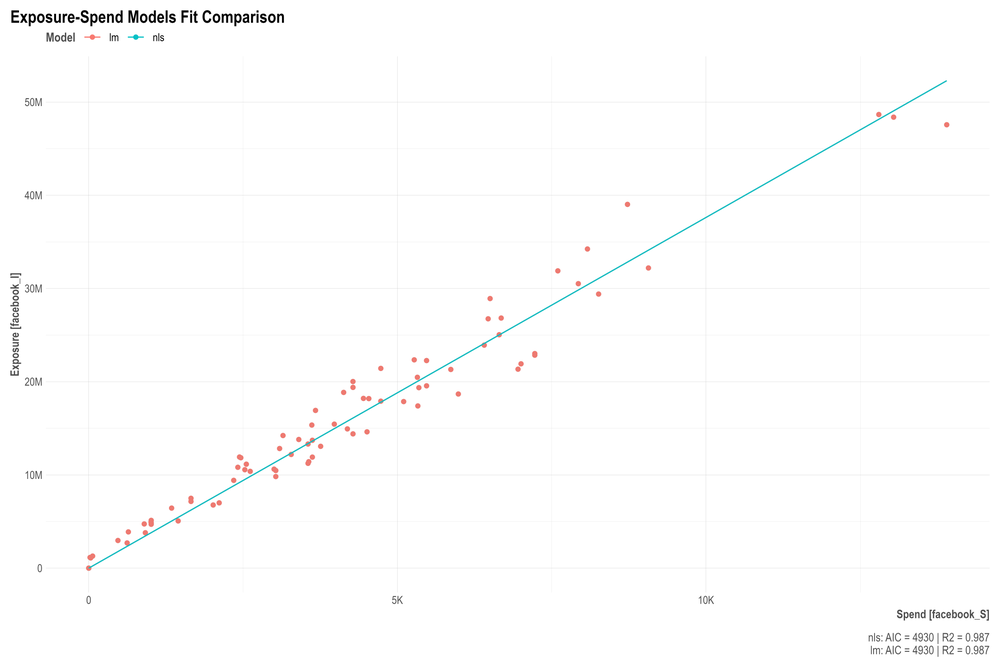

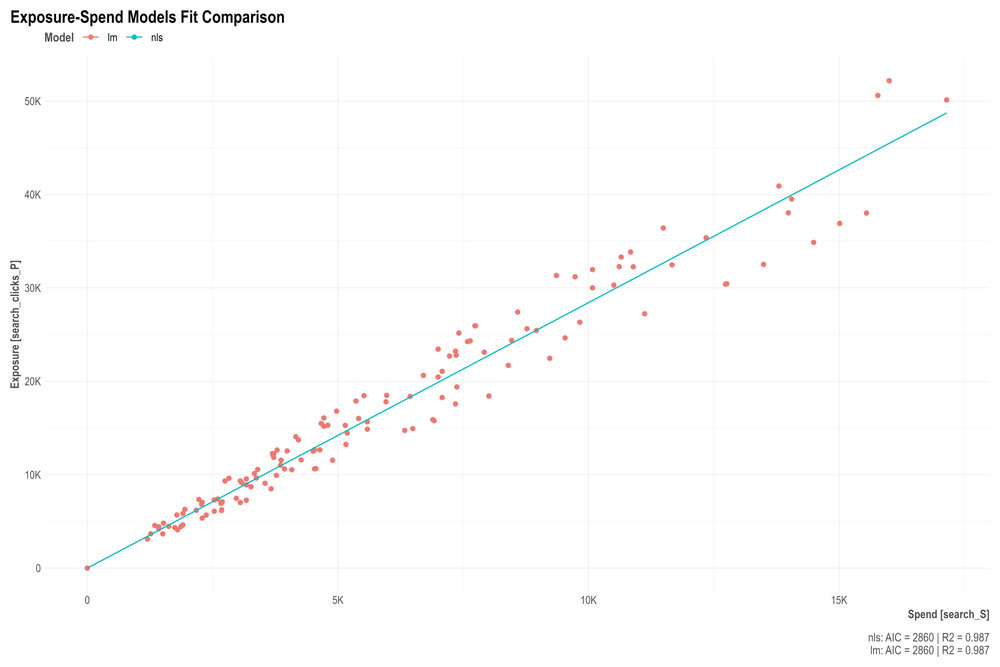

In [20]:
#max_size is deafulted to 1000 x 1500 but can be changed
render_spendexposure(InputJson=InputCollect,max_size=(1000,1500))

## Step 3: Build initial model <a class="anchor" id="step-3-build-initial-model"></a>
Run all trials and iterations.

In [21]:
runArgs = {
    "iterations" : 2000, # NULL defaults to (max available - 1)
    "trials" : 5, # 5 recommended for the dummy dataset
    "ts_validation" : True,  # 3-way-split time series for NRMSE validation.
    "add_penalty_factor" : False, # Experimental feature. Use with caution.
}

# Build the payload for the robyn_run()
payload = {
    'InputCollect' : json.dumps(InputCollect), 
    'jsonRunArgs' : json.dumps(runArgs)
}

In [22]:
# Get response
OutputModels = robyn_api('robyn_run',payload=payload)

Input data has 208 weeks in total: 2015-11-23 to 2019-11-11
Initial model is built on rolling window of 157 week: 2016-01-04 to 2018-12-31
Time-series validation with train_size range of 50%-80% of the data...
Using geometric adstocking with 20 hyperparameters (20 to iterate + 0 fixed) on 9 cores
>>> Starting 5 trials with 2000 iterations each using TwoPointsDE nevergrad algorithm...
  Running trial 1 of 5


  |======================================================================| 100%
  Finished in 0.89 mins
  |                                                                      |   0%

  Running trial 2 of 5


  |======================================================================| 100%
  Finished in 0.92 mins
  |                                                                      |   0%

  Running trial 3 of 5


  |======================================================================| 100%
  Finished in 0.94 mins
  |                                                                      |   0%

  Running trial 4 of 5


  |======================================================================| 100%
  Finished in 0.89 mins
  |                                                                      |   0%

  Running trial 5 of 5


  |======================================================================| 100%
  Finished in 0.82 mins


- DECOMP.RSSD NOT converged: sd@qt.20 0.097 > 0.066 & |med@qt.20| 0.21 <= 0.59
- NRMSE converged: sd@qt.20 0.019 <= 0.062 & |med@qt.20| 0.11 <= 0.15
Total run time: 4.61 mins


### Check MOO (multi-objective optimization) convergence plots

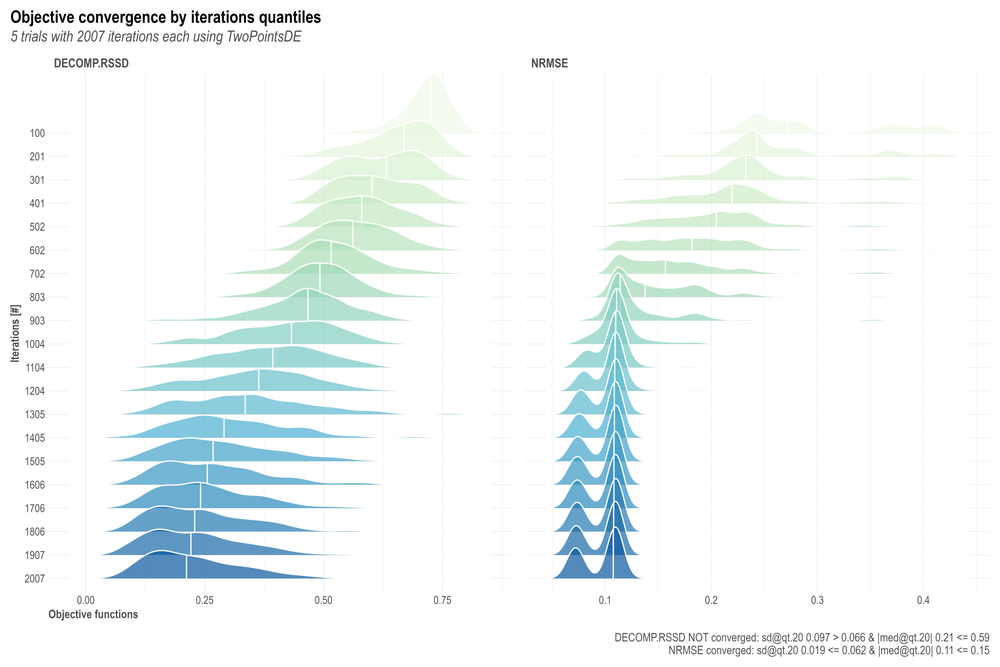

In [23]:
plot_outputgraphs(OutputModels,graphtype='moo_distrb_plot',max_size=(1000, 1500),argumenttype='none')

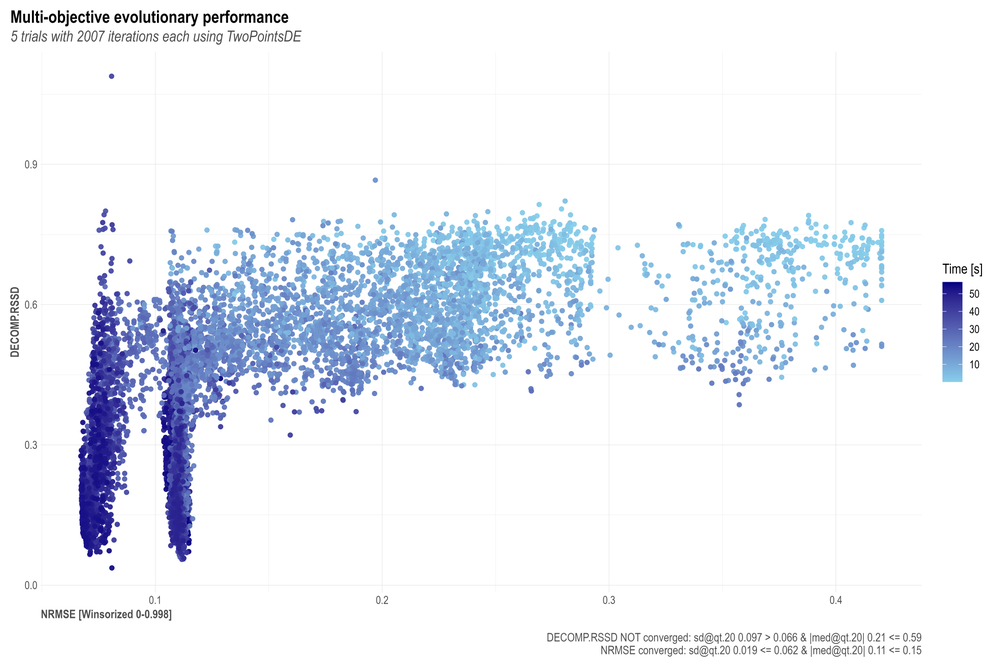

In [24]:
plot_outputgraphs(OutputModels,graphtype='moo_cloud_plot',max_size=(1000, 1500),argumenttype='none')

### Check time-series validation plot (when ts_validation == TRUE)

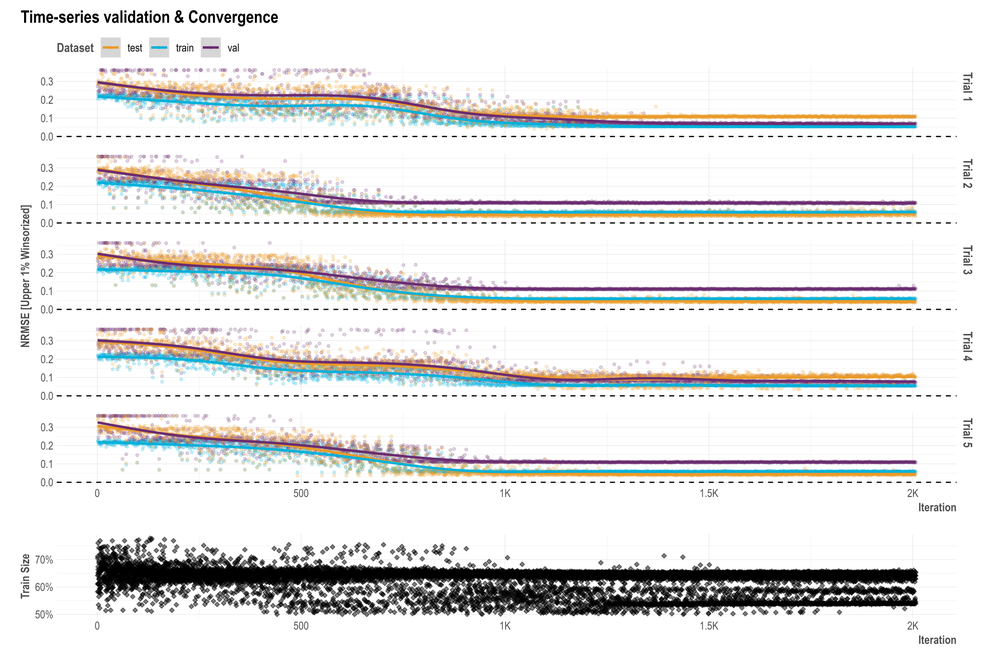

In [25]:
plot_outputgraphs(OutputModels,graphtype='ts_validation_plot',max_size=(1000, 1500),argumenttype='none')

### Calculate Pareto fronts, cluster and export results and plots.

In [26]:
outputsArgs = {
    "pareto_fronts" : 'auto', # automatically pick how many pareto-fronts to fill min_candidates (100)
#     "min_candidates" : 100, # top pareto models for clustering. Default to 100
#     "calibration_constraint" : 0.1, # range [0.01, 0.1] & default at 0.1
    "csv_out" : "pareto", # "pareto", "all", or NULL (for none)
    "clusters" : True, # Set to TRUE to cluster similar models by ROAS.
    "export" : create_files, # this will create files locally
    "plot_folder" : robyn_directory, # path for plots exports and files creation
    "plot_pareto" : create_files # Set to FALSE to deactivate plotting and saving model one-pagers
}

# Build the payload for the robyn_outputs()
payload = {
    'InputCollect' : json.dumps(InputCollect),
    'OutputModels' : json.dumps(OutputModels),
    'jsonOutputsArgs' : json.dumps(outputsArgs)
}

In [27]:
# Get response
OutputCollect = robyn_api('robyn_outputs',payload=payload)

>>> Running Pareto calculations for 10000 models on auto fronts...
>> Automatically selected 5 Pareto-fronts to contain at least 100 pareto-optimal models (116)
>>> Calculating response curves for all models' media variables (580)...
>> Pareto-Front: 1 [27 models]


 00:00:02 [=========================================] 100% | 27                      
 00:00:00 [====                                     ] 8% | 2                      

>> Pareto-Front: 2 [25 models]


 00:00:02 [=========================================] 100% | 25                      
 00:00:00 [==                                       ] 3.45% | 1                      

>> Pareto-Front: 3 [29 models]


 00:00:02 [=========================================] 100% | 29                      
 00:00:00 [======                                   ] 13.3% | 2                      

>> Pareto-Front: 4 [15 models]


 00:00:01 [=========================================] 100% | 15                      
 00:00:00 [=====                                    ] 10% | 2                      

>> Pareto-Front: 5 [20 models]


 00:00:01 [=========================================] 100% | 20                      


Creating directory for outputs: /Users/yuyatanaka/Desktop/Robyn_202405050127_init/
>>> Calculating clusters for model selection using Pareto fronts...
>> Auto selected k = 10 (clusters) based on minimum WSS variance of 6%
>>> Collecting 116 pareto-optimum results into: /Users/yuyatanaka/Desktop/Robyn_202405050127_init/
>> Exporting general plots into directory...
>> Exporting pareto results as CSVs into directory...
>>> Exporting pareto one-pagers into directory...
>> Generating only cluster results one-pagers (10)...
>> Plotting 10 selected models on 1 core (MacOS fallback)...


  |======================================================================| 100%


>> Exported model models as /Users/yuyatanaka/Desktop/Robyn_202405050127_init/RobynModel-models.json


In [28]:
for i in OutputCollect['clusters']['models']:
    print(i['solID'])

1_200_7
1_202_9
1_221_3
1_176_6
1_180_2
1_214_2
1_196_7
1_222_8
1_212_4
5_181_7


In [ ]:
# OutputCollect['allSolutions']

#### 4 csv files are exported into the folder for further usage.
- Check schema here: https://github.com/facebookexperimental/Robyn/blob/main/demo/schema.R  
- pareto_hyperparameters.csv, hyperparameters per Pareto output model  
- pareto_aggregated.csv, aggregated decomposition per independent variable of all Pareto output  
- pareto_media_transform_matrix.csv, all media transformation vectors  
- pareto_alldecomp_matrix.csv, all decomposition vectors of independent variables

## Step 4: Select and save the any model <a class="anchor" id="step-4-select-and-save"></a>

### Compare all model one-pagers and select one that mostly reflects your business reality

Fetching one pager data for top models


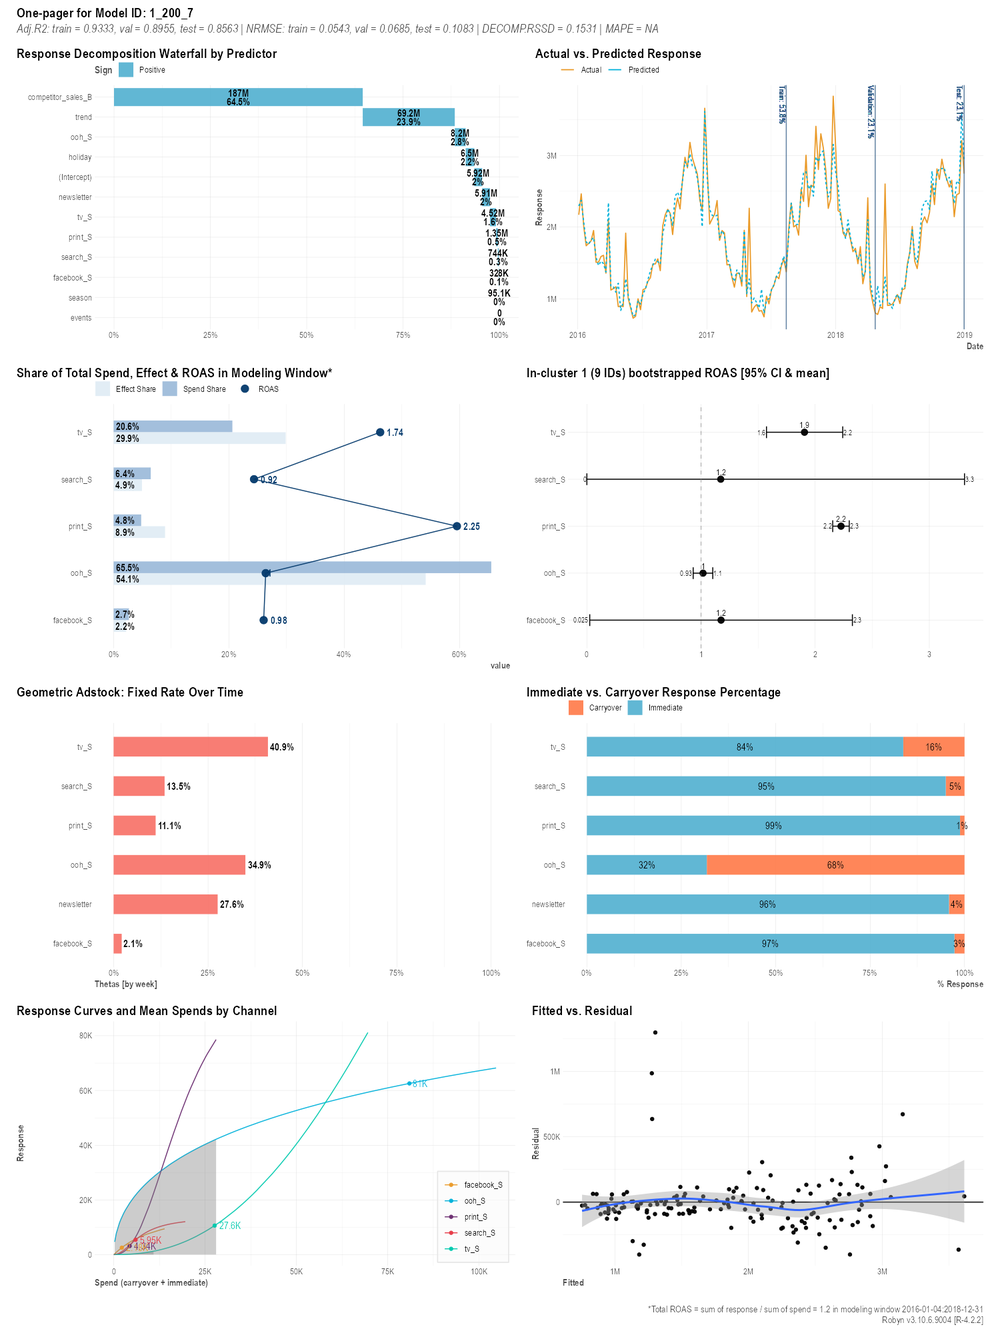

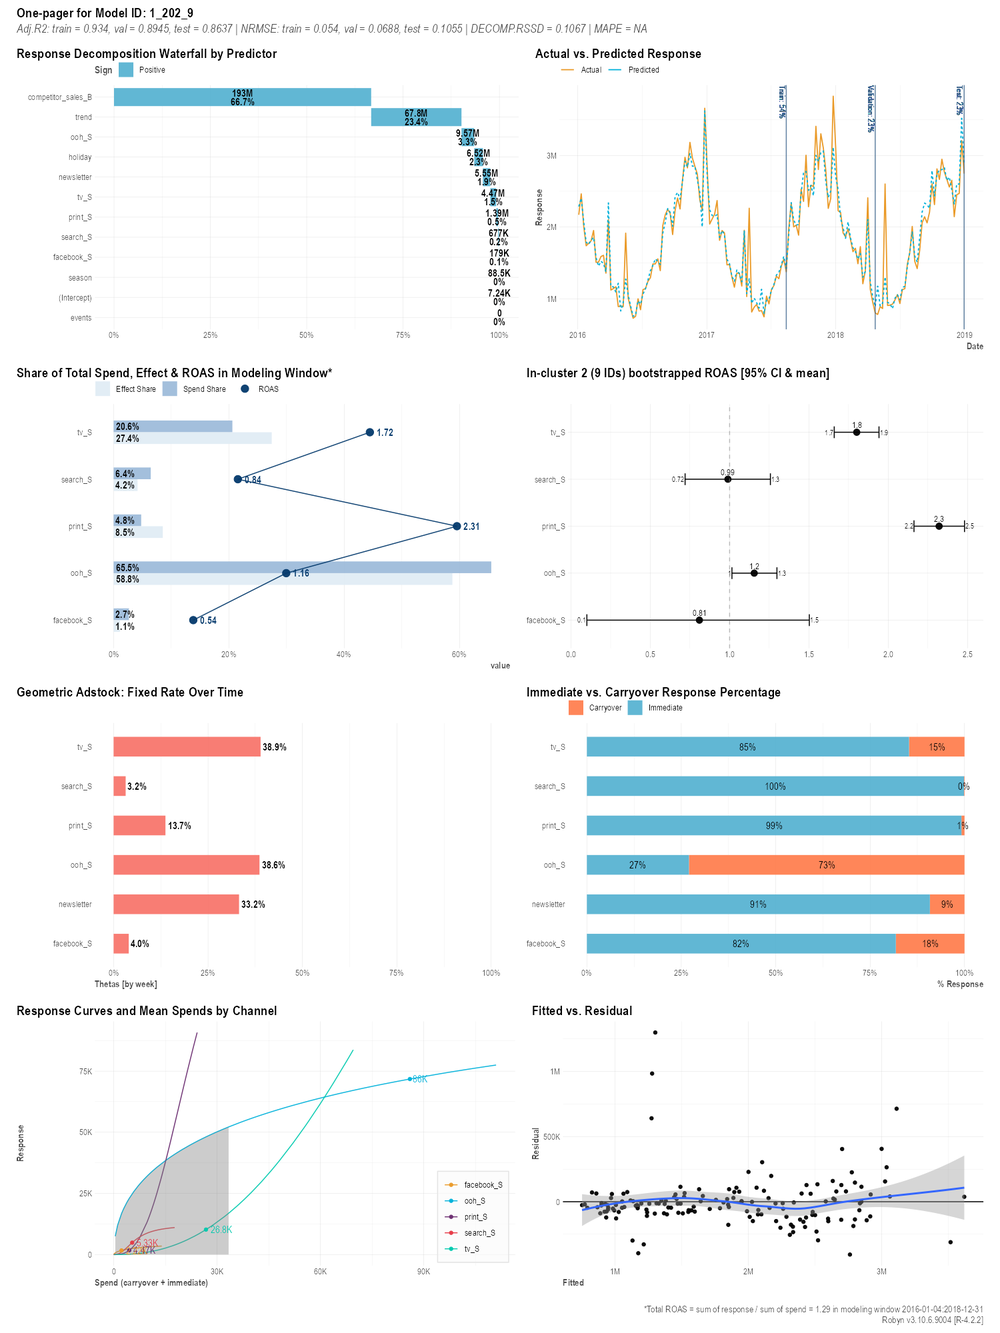

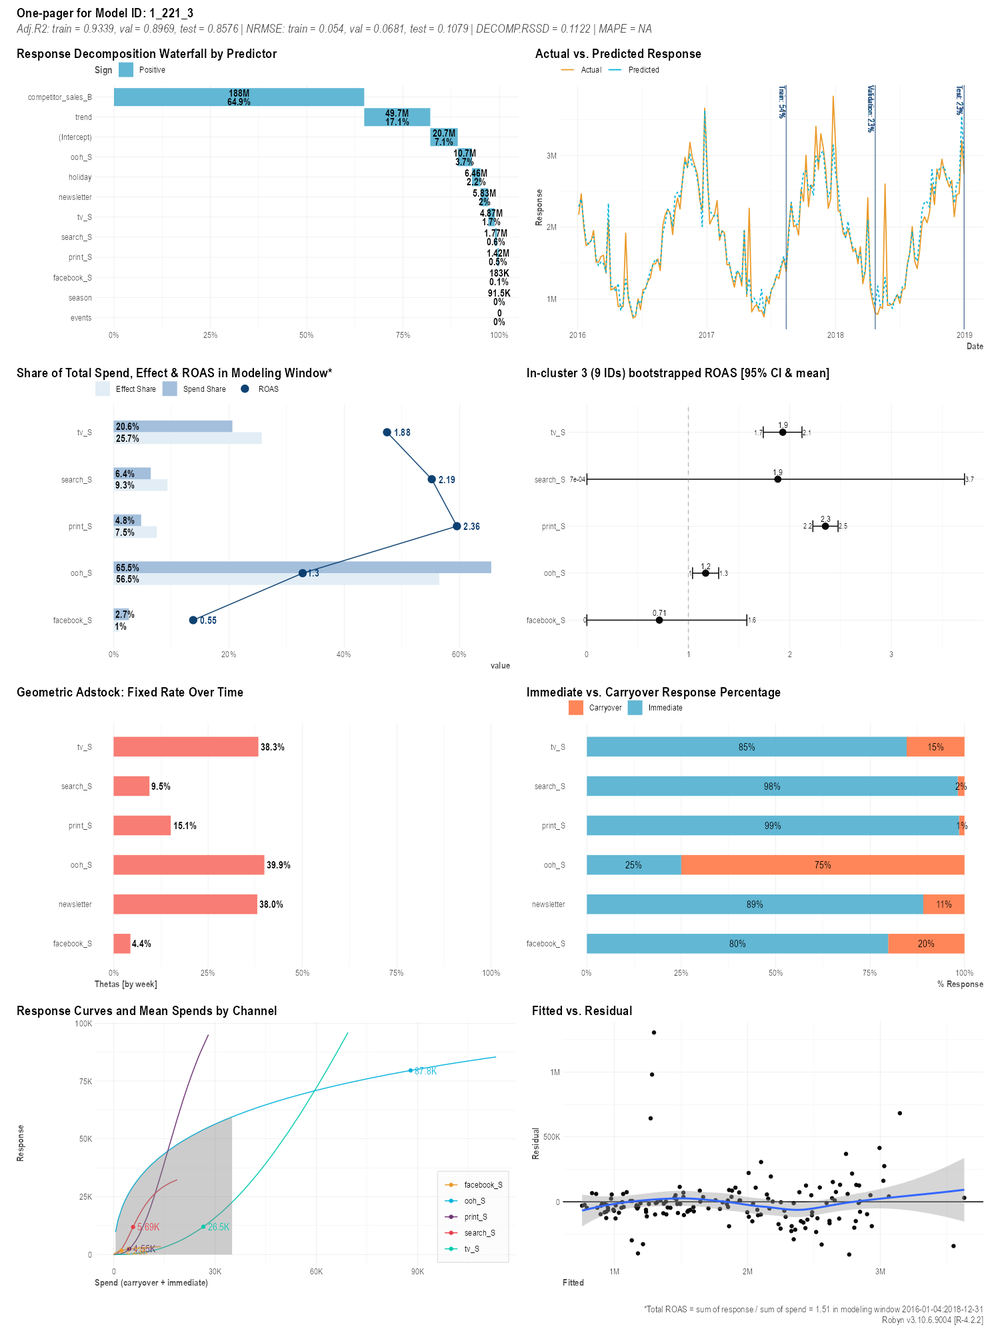

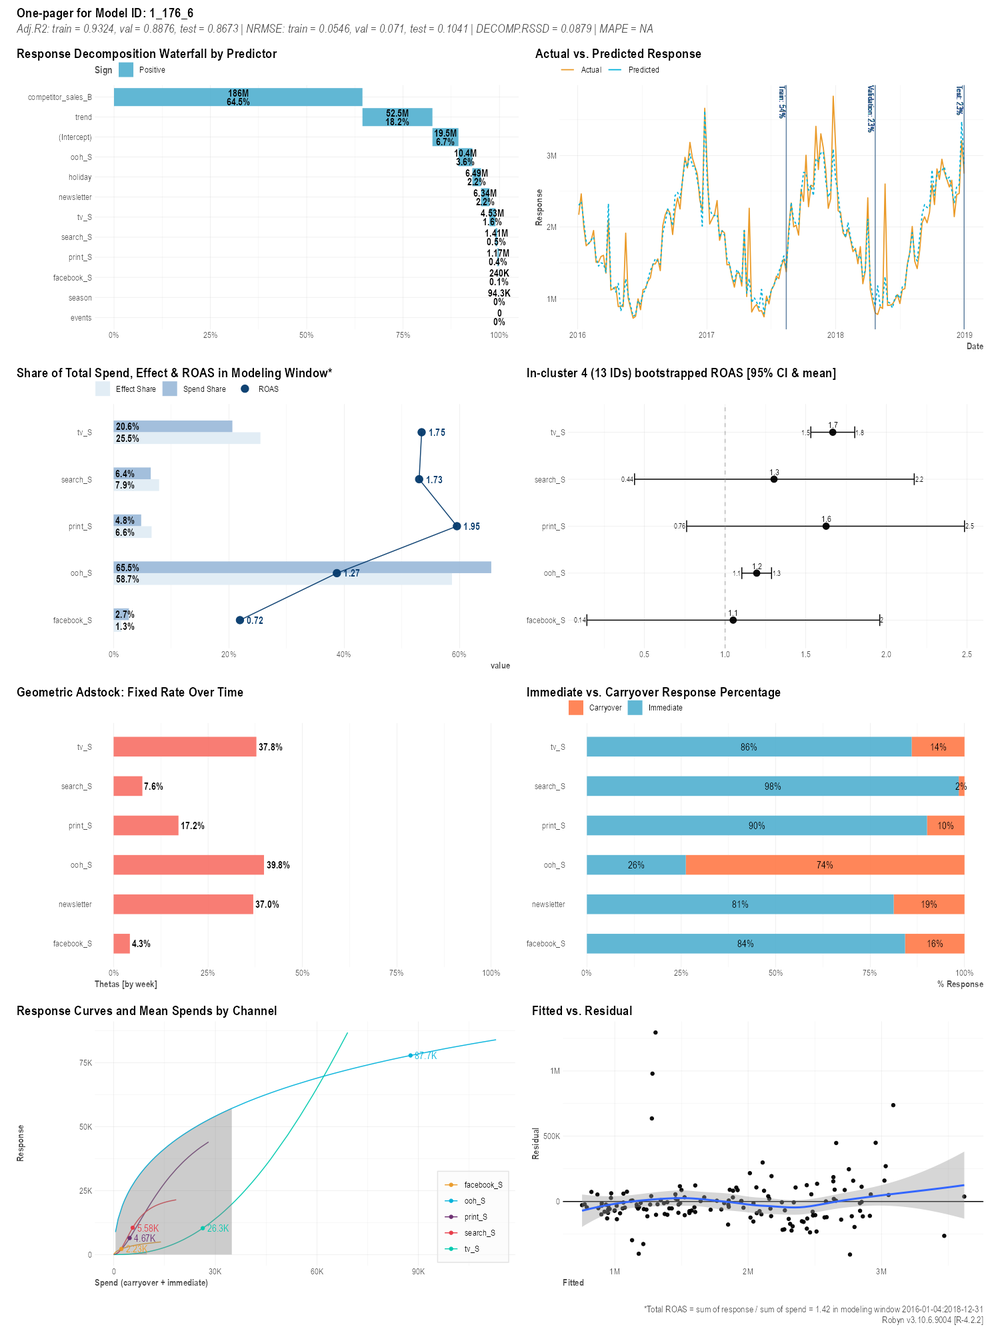

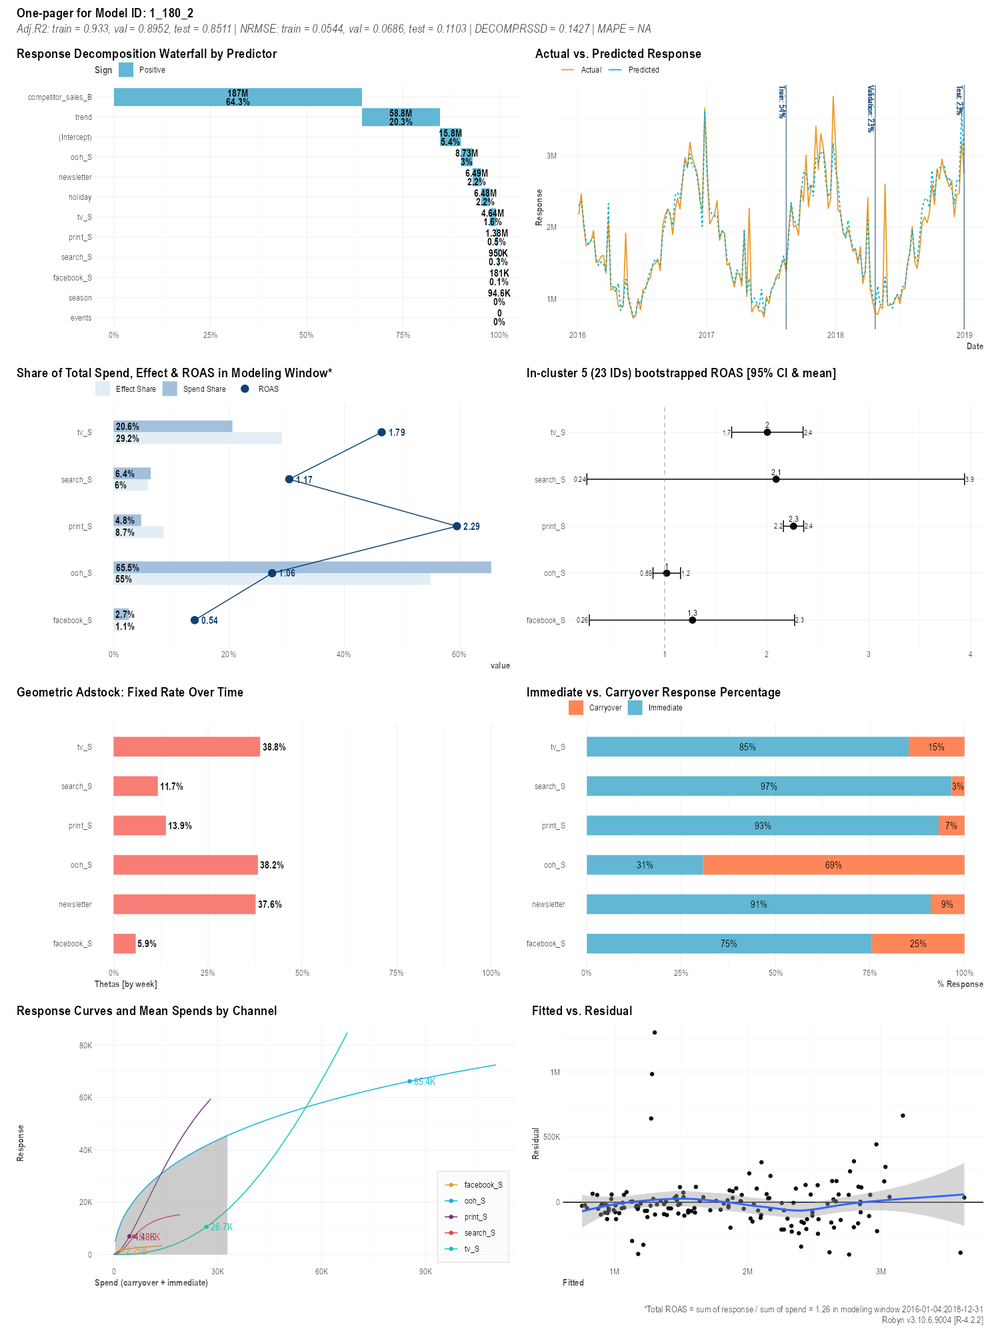

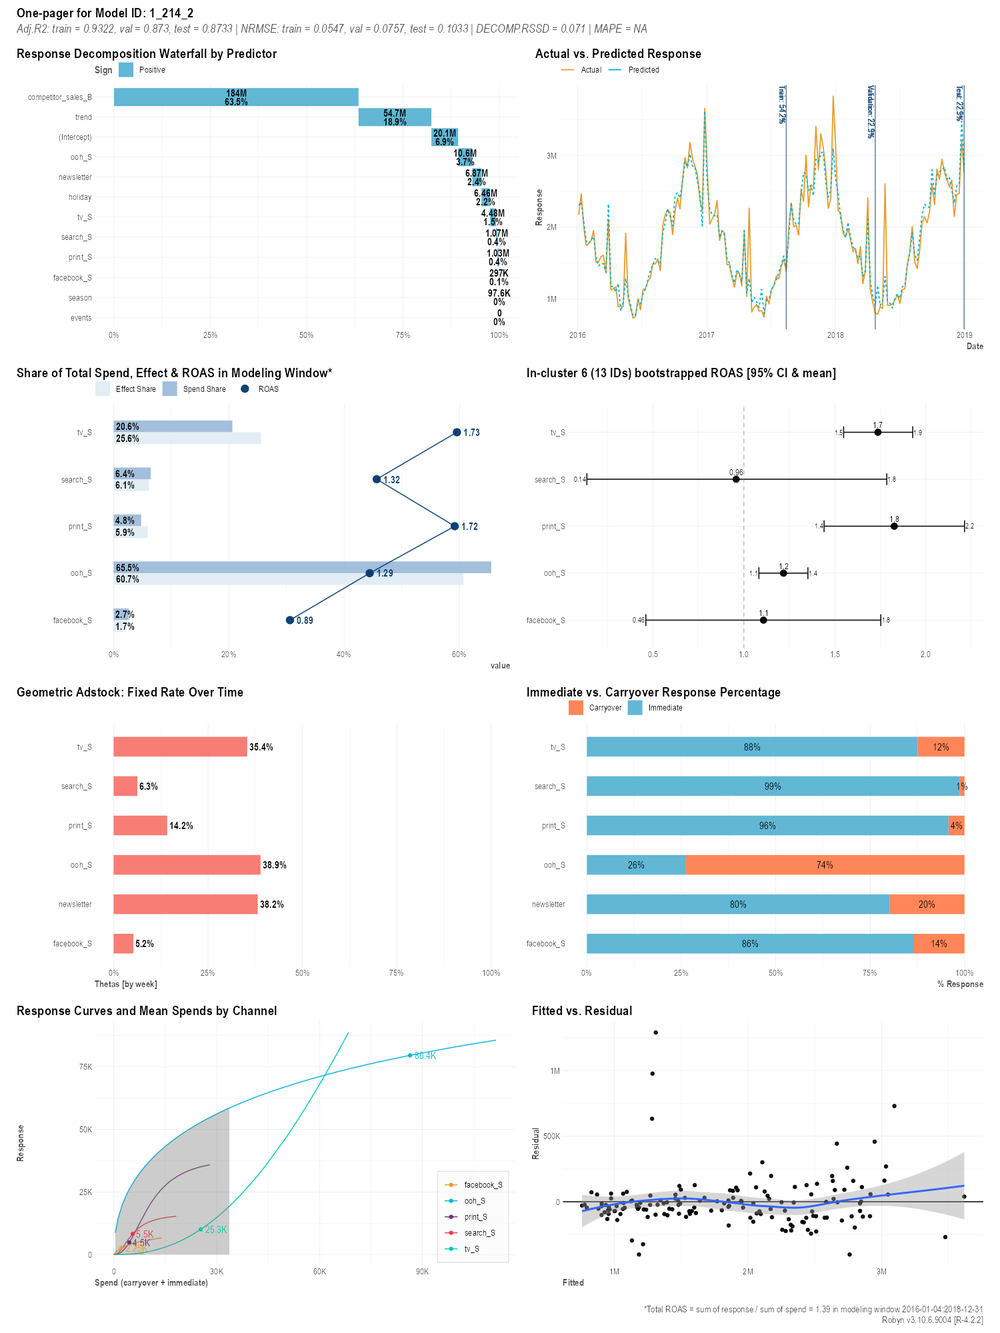

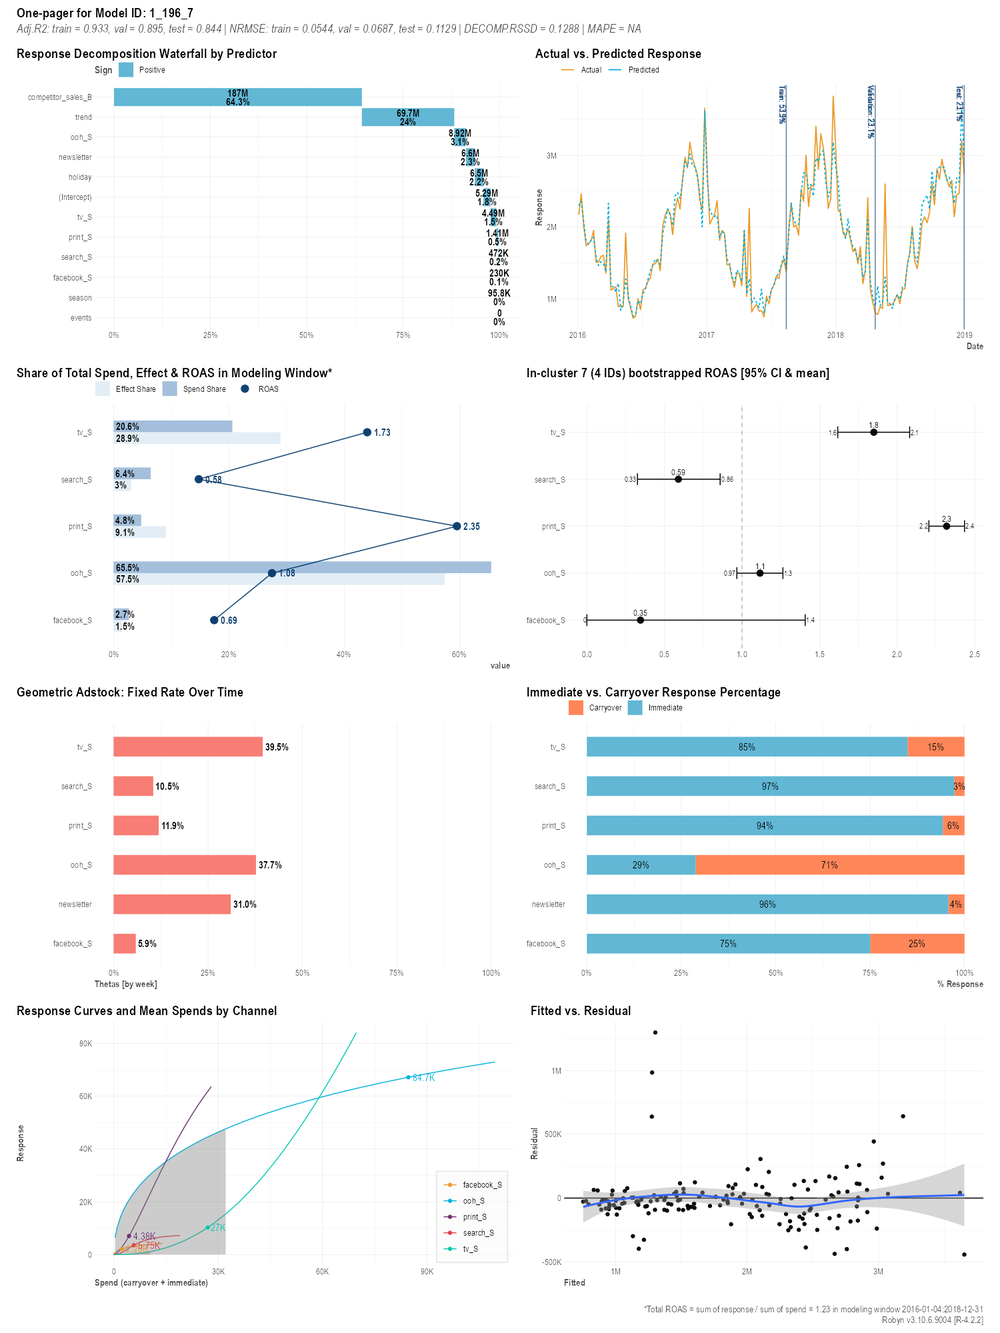

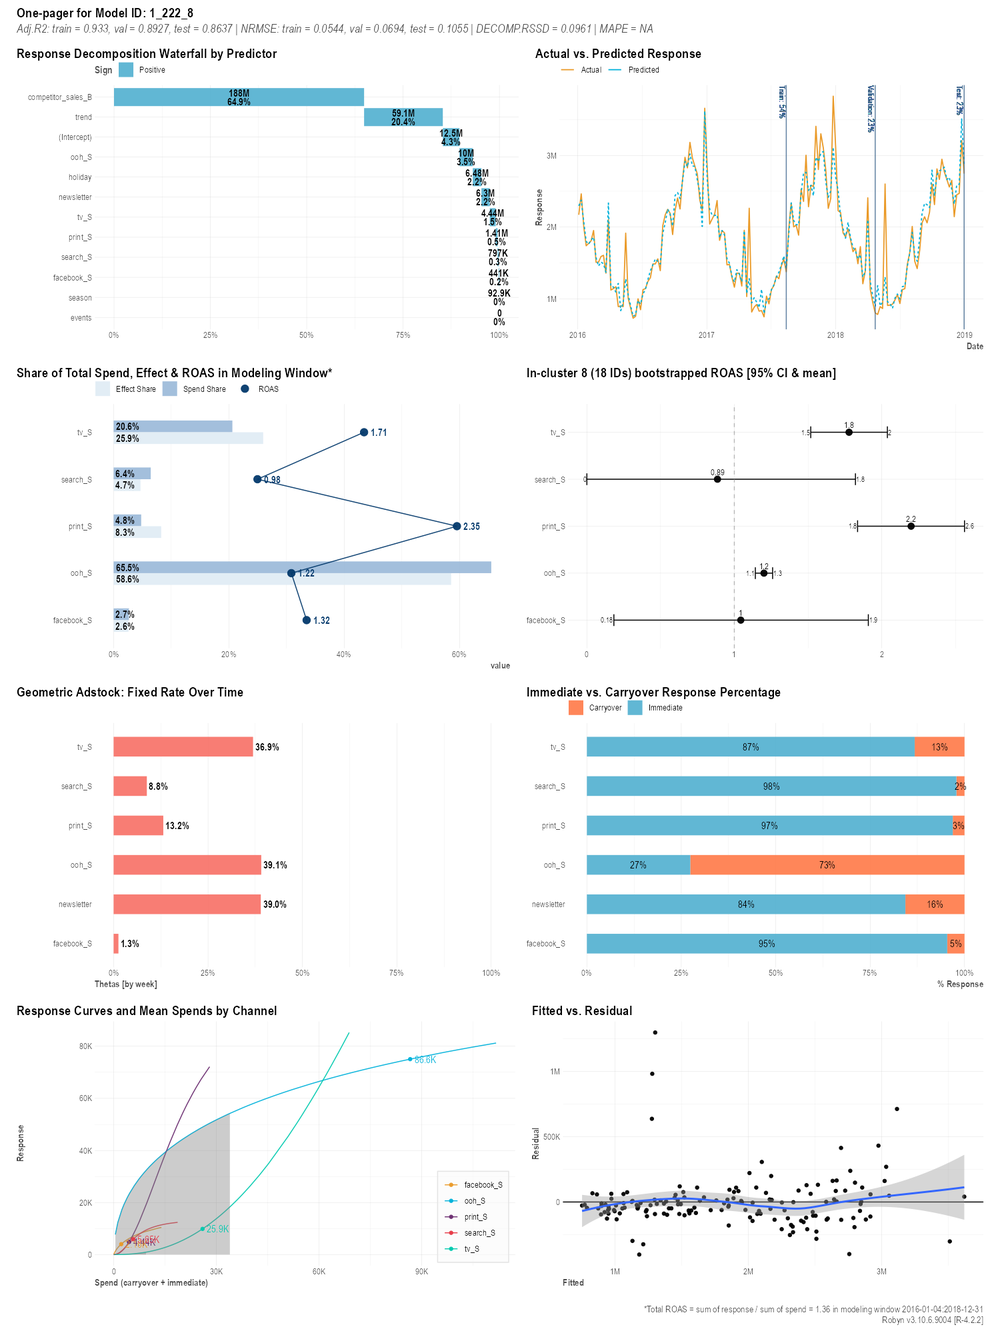

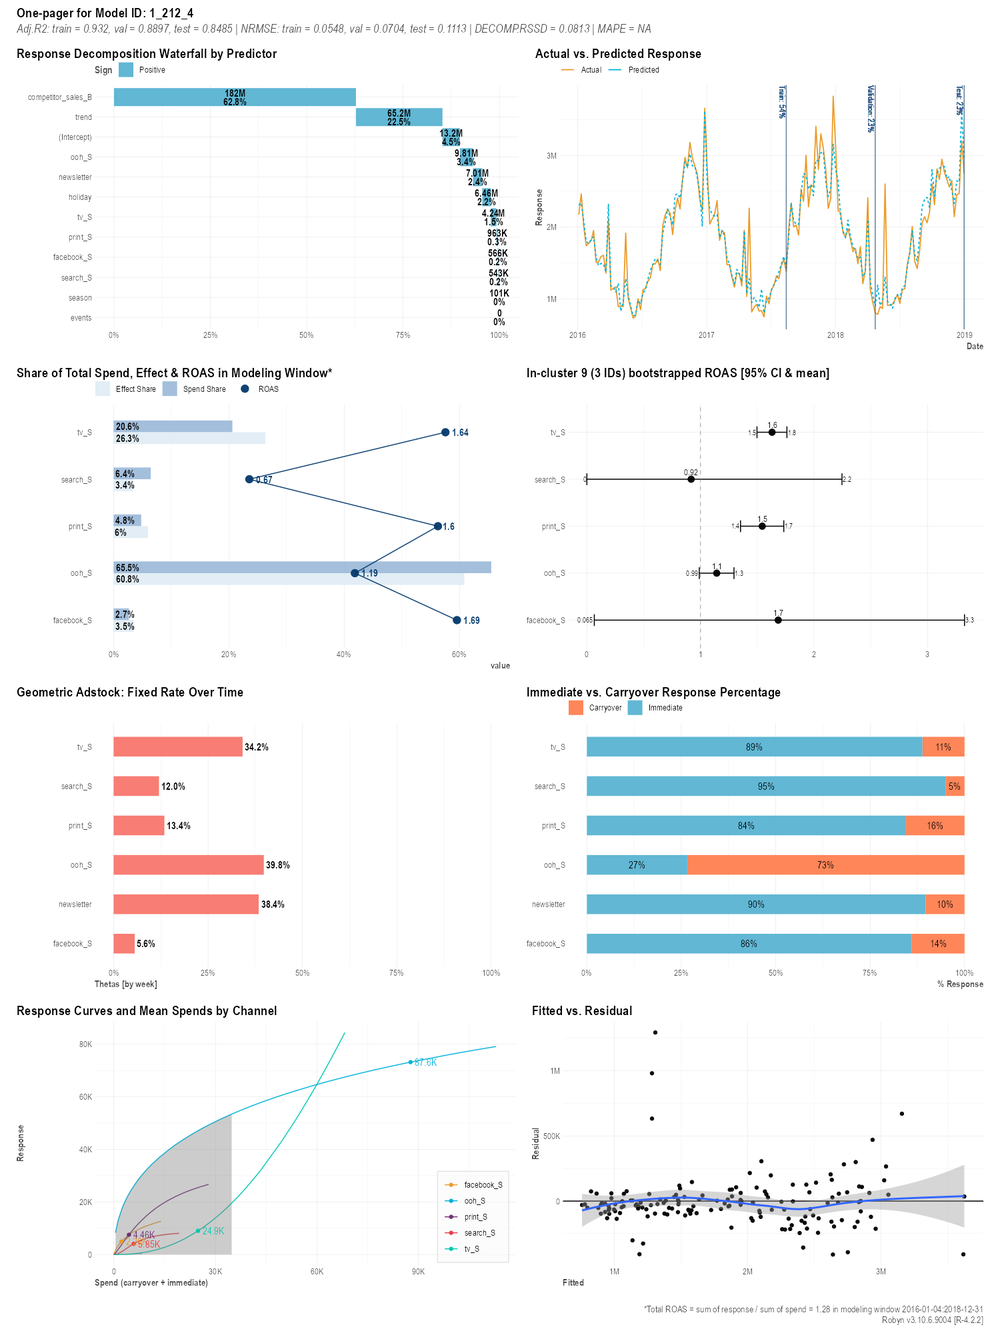

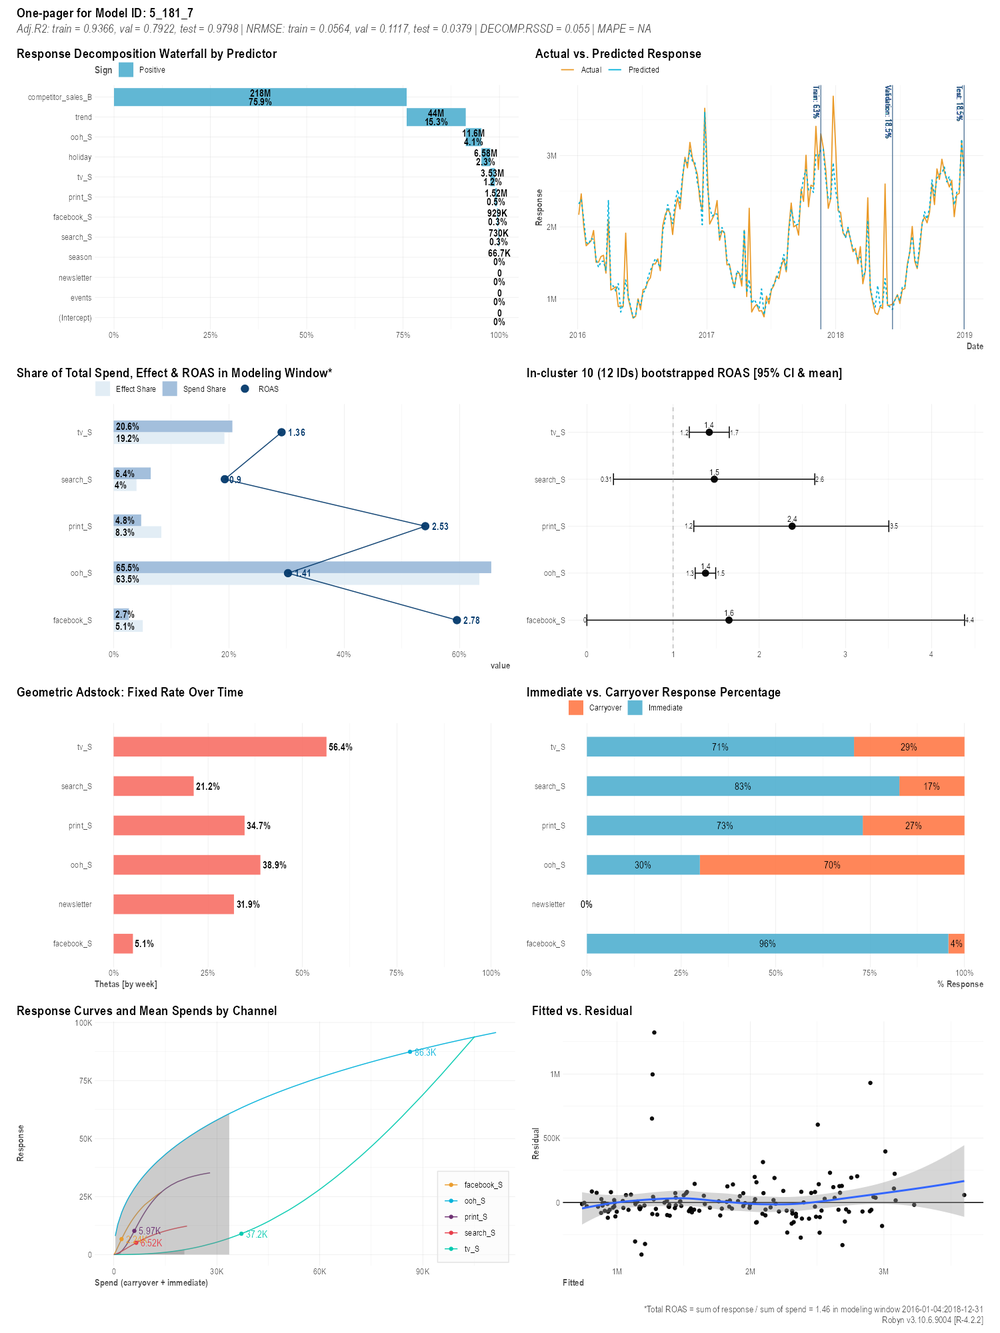

In [29]:
#Load one pagers for top models
load_onepager(top_pareto=True,sol='all',InputJson=InputCollect,OutputJson=OutputCollect,path=robyn_directory)

Fetching one pager for specified solution id
Using specified path
Path exists:  /Users/yuyatanaka/Desktop/
Onepager written to path: /Users/yuyatanaka/Desktop/1_200_7


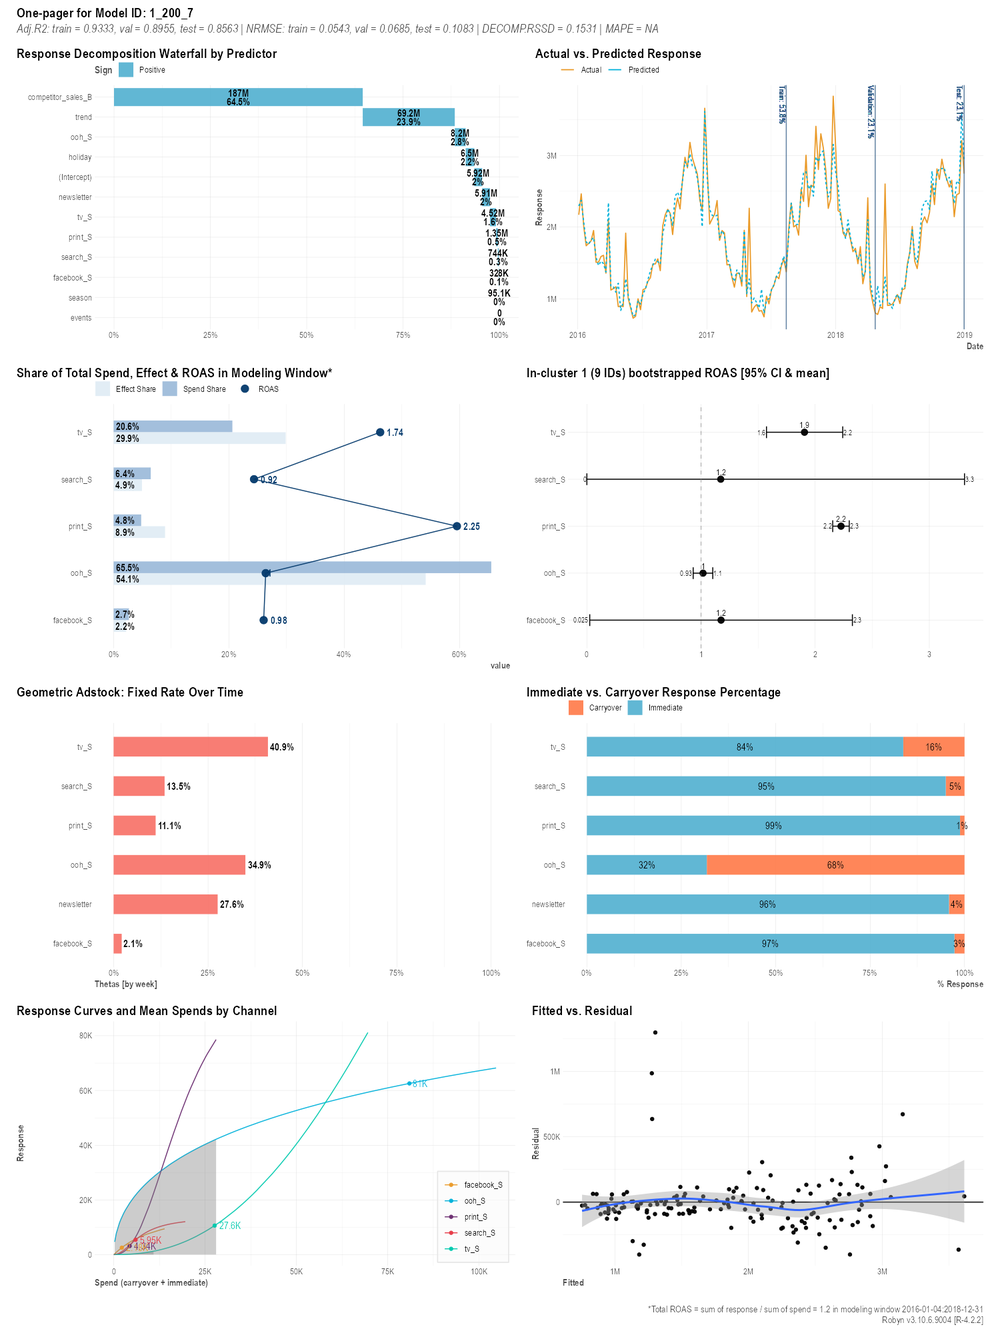

In [30]:
#write one pager to specified location
load_onepager(sol='1_200_7',write=True,InputJson=InputCollect,OutputJson=OutputCollect,path=robyn_directory)

### Write Robyn outcomes

In [31]:
write_robynmodel(sol='1_200_7',path=robyn_directory,InputJson=InputCollect,OutputJson=OutputCollect,OutputModels=OutputModels)

Using specified path
Path exists:  /Users/yuyatanaka/Desktop/


>> Exported model 1_200_7 as /Users/yuyatanaka/Desktop/RobynModel-1_200_7.json


File written to path:  /Users/yuyatanaka/Desktop/


### To plot any model's one-pager:

Fetching one pager for specified solution id


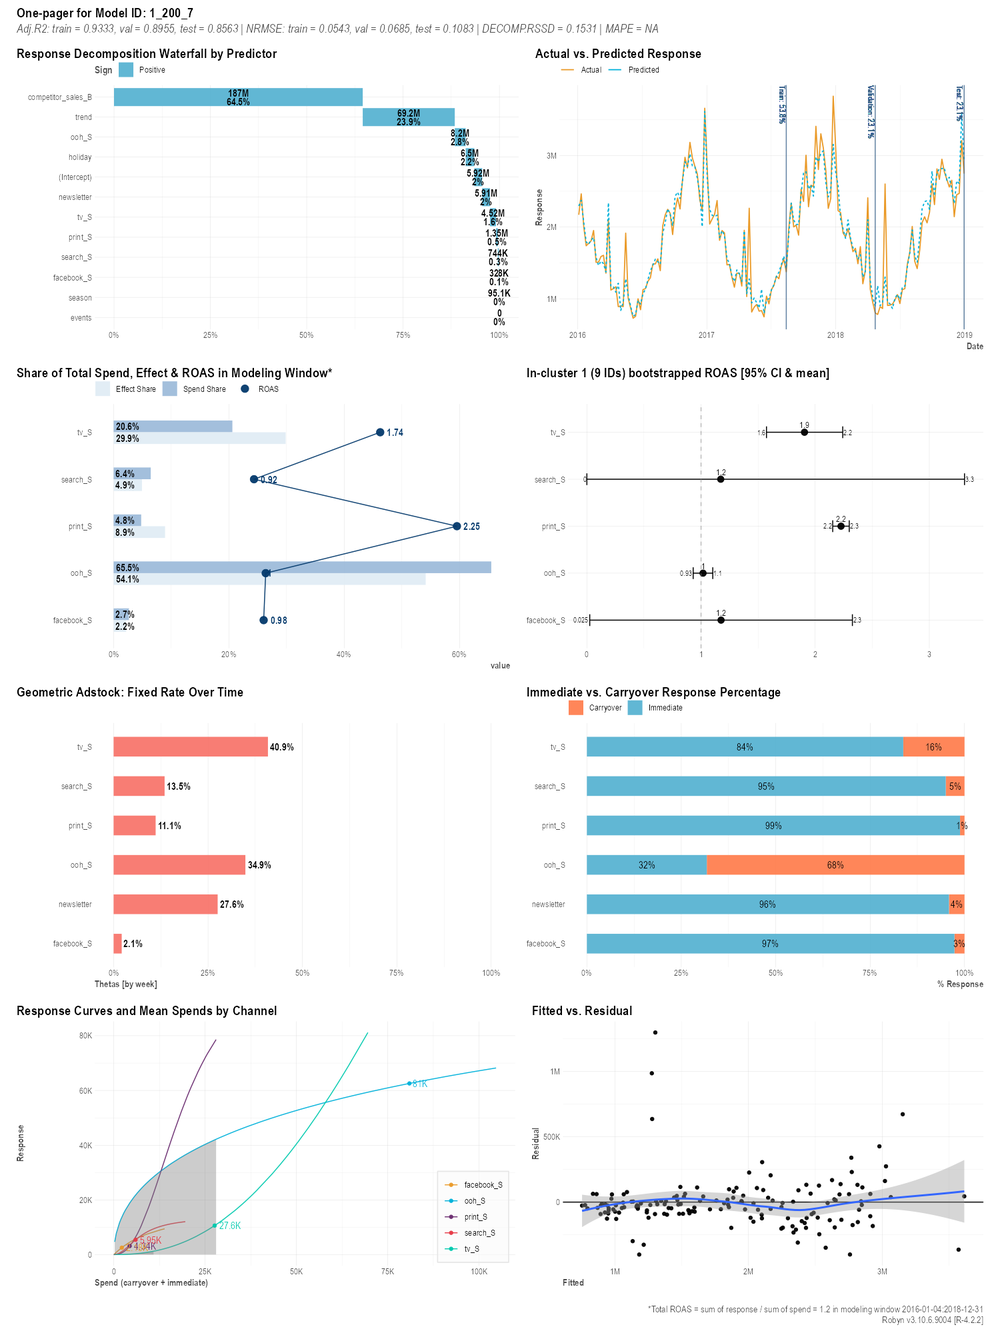

In [32]:
load_onepager(sol='1_200_7',InputJson=InputCollect,OutputJson=OutputCollect,path=robyn_directory)

## Step 5: Get budget allocation based on the selected model above <a class="anchor" id="step-5-get-budget-allocation"></a>
Budget allocation result requires further validation. Please use this recommendation with caution.  
Don't interpret budget allocation result if selected model above doesn't meet business expectation.

In [33]:
# NOTE: The order of constraints should follow:
InputCollect['paid_media_spends']

['tv_S', 'ooh_S', 'print_S', 'facebook_S', 'search_S']

Scenario "max_response": "What's the max. return given certain spend?"  
Example: max_response defaultsetting: maximize response for latest month

In [34]:
select_model='1_200_7'

allocatorArgs = {
    "select_model" : select_model,
#     "date_range" : None, # Default last month as initial period
#     "total_budget" : None, # When NULL, default is total spend in date_range
    "channel_constr_low" : 0.7,
    "channel_constr_up" : 1.2,
    "channel_constr_multiplier" : 3,
    "scenario" : "max_response"
}

In [35]:
# Build the payload for the robyn_allocator()
payload = {
    'InputCollect' : json.dumps(InputCollect),
    'OutputCollect' : json.dumps(OutputCollect),
    "jsonAllocatorArgs": json.dumps(allocatorArgs),
    'dpi' : 100,
    'width' : 15,
    'height' : 15
}

In [36]:
# Get response
allocator = robyn_api('robyn_allocator',payload=payload)

>>> Running budget allocator for model ID 1_200_7 ...
Date Window: 2016-01-04:2018-12-31 (157 weeks)
Warning in min(diff(unique_loc)) :
  no non-missing arguments to min; returning Inf
Exporting to: /Users/yuyatanaka/Desktop/Robyn_202405050127_init/1_200_7_reallocated_best_roas.png
Warning in min(diff(unique_loc)) :
  no non-missing arguments to min; returning Inf


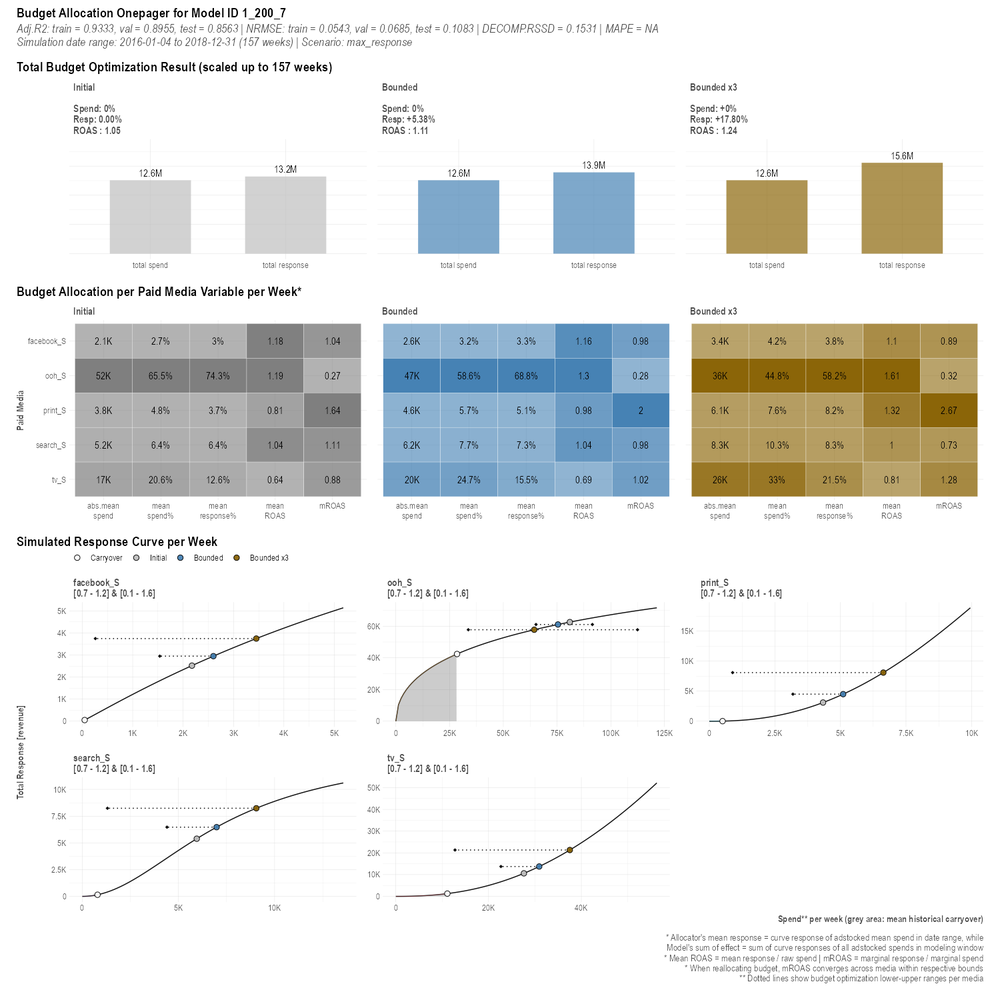

In [37]:
plot_outputgraphs(OutputJson='none',argumenttype=allocator,graphtype='allocator',max_size=(1000, 1500))

## Optional: recreate old models and replicate results
From an exported JSON file (which is created automatically when exporting a model) we can re-create a previously trained model and outputs.  
Note: we need to provide the main dataset and the holidays dataset, which are NOT stored in the JSON file.  

### Re-create InputCollect and OutputCollect by simply using endpoint `robyn_recreate/`

In [38]:
recreateArgs = {
    "json_file" : "~/Desktop/RobynModel-1_200_7.json",
    "quiet" : False
}

In [39]:
# Build the payload for the robyn_recreate()
payload = {
    'dt_input' : asSerialisedFeather(dt_simulated_weekly), 
    'dt_holidays' : asSerialisedFeather(dt_prophet_holidays), 
    "jsonRecreateArgs": json.dumps(recreateArgs)
}

In [40]:
# Get response
RobynRecreated = robyn_api('robyn_recreate',payload=payload)

>>> Recreating model 1_200_7
Imported JSON file successfully: ~/Desktop/RobynModel-1_200_7.json
>> Running feature engineering...
Input data has 208 weeks in total: 2015-11-23 to 2019-11-11
Initial model is built on rolling window of 157 week: 2016-01-04 to 2018-12-31
>>> Calculating response curves for all models' media variables (5)...
Successfully recreated model ID: 1_200_7


In [41]:
InputCollectX = RobynRecreated['InputCollect']
InputCollectX.keys()

dict_keys(['dt_input', 'dt_holidays', 'dt_mod', 'dt_modRollWind', 'xDecompAggPrev', 'date_var', 'dayInterval', 'intervalType', 'dep_var', 'dep_var_type', 'prophet_vars', 'prophet_signs', 'prophet_country', 'context_vars', 'context_signs', 'paid_media_vars', 'paid_media_signs', 'paid_media_spends', 'paid_media_total', 'exposure_vars', 'organic_vars', 'organic_signs', 'all_media', 'all_ind_vars', 'factor_vars', 'unused_vars', 'window_start', 'rollingWindowStartWhich', 'window_end', 'rollingWindowEndWhich', 'rollingWindowLength', 'totalObservations', 'refreshAddedStart', 'adstock', 'hyperparameters', 'calibration_input', 'custom_params', 'dt_inputRollWind', 'modNLS', 'version'])

In [42]:
OutputCollectX = RobynRecreated['OutputCollect']
OutputCollectX.keys()

dict_keys(['resultHypParam', 'xDecompAgg', 'mediaVecCollect', 'xDecompVecCollect', 'resultCalibration', 'allSolutions', 'allPareto', 'calibration_constraint', 'OutputModels', 'cores', 'iterations', 'trials', 'intercept', 'intercept_sign', 'nevergrad_algo', 'add_penalty_factor', 'seed', 'UI', 'pareto_fronts', 'hyper_fixed', 'plot_folder', 'hyper_updated', 'clusters', 'selectID'])